# Pytorch Tutorial #01
# CNN with Pytorch Sequential and Functional API

by Francesco G. Fantauzzi
/ [GitHub](https://github.com/fantauzzi/Pytorch-Tutorials)

Adapted from [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/) tutorial
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials/03C_Keras_API.ipynb) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

# WIP - Work in Progress

## Introduction

This tutorial uses Pytorch to implement a Convolutional Neural Network (CNN) for handwritten digits recognition, trained on the MNIST dataset. The tutorial demonstrates two different programming styles to define the Neural Network model, called "sequential" and "functional", supported by Pytorch. 

Interestingly enough, Keras already supports two similar programming styles for model definition. Unlike Keras, Pytorch currently doesn't infer the shape of the tensors going into a layer based on the output of the previous layer; the programmer needs to code it. At least, determining the shape of a tensor with Pytorch is as easy as inspecting a variable via debugger.

I have ported Magnus Pedersen's fine [tutorial](https://github.com/Hvass-Labs/TensorFlow-Tutorials) from Keras/Tensorflow to Pytorch, as a self-teaching exercise. I appreciated how easier it is to debug a model with Pytorch, as one can step through the computation and inspect any tensor or variable with a Python debugger, like for any Python program.

In porting Mr. Pedersen's tutorial I have reworked the code to use Pytorch API, and updated the narrative conequently, keeping what I could.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See Tutorial #02 of Mr. Pedersen's for a more detailed description of convolution.

There are two convolutional layers, each followed by a RELU and down-sampling using max-pooling (not shown in this flowchart). Then there are two fully-connected layers ending in a classifier. Note that in the original Keras tutorial it is a softmax classifier, while here the output of the NN is just an array of 10 scores, not probabilities. That is because of the adopted loss function, see below for more information on this.

![Flowchart](images/02_network_flowchart.png)

## Imports

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.autograd import Variable

##### This was developed using Python 3.5 and Pytorch version:

In [2]:
torch.__version__

'0.3.0.post4'

## Set the Dataset Loaders

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cuda = torch.cuda.is_available()

batch_size = 128
test_batch_size = 128
epochs = 4

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is partitioned into 2 sub-sets, a training-set and a test-set.

In [4]:
# This may take several seconds to run, as it reads the whole dataset from storage.
test_data_iter = iter(test_loader)
test_set_size = sum(len(batch[0]) for batch in test_data_iter)
training_data_iter = iter(train_loader)
training_set_size = sum(len(batch[0]) for batch in training_data_iter)

print("Size of:")
print("- Training-set:\t\t{}".format(training_set_size))
print("- Test-set:\t\t{}".format(test_set_size))

Size of:
- Training-set:		60000
- Test-set:		10000


## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [5]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

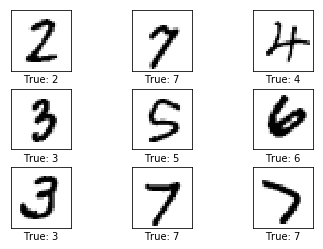

In [7]:
''' Fetch nine images from the training-set and plot them. Note they can differ from run to run, as the
training-set gets shuffled ''' 

sample_data_iter = iter(train_loader)
images, labels = sample_data_iter.next()
images = images.numpy()[0:9]
labels = labels.numpy()[0:9]
plot_images(images, labels)

### Helper-functions to plot classified and misclassified images

Functions for plotting examples of images from the dataset-set that along with their classification.

In [17]:
def array_from_variable(var):
    return var.cpu().data.numpy()


def array_from_tensor(tensor):
    return tensor.cpu().numpy()


def plot_classified_sample(dataset_loader, model):
    data_iter = iter(dataset_loader)
    images, labels = data_iter.next()
    images = images[0:9]
    labels = labels.numpy()[0:9]
    if cuda:
        images = images.cuda()
    images = Variable(images, volatile=True)
    pred_scores = model(images)
    predicted = pred_scores.data.max(1, keepdim=True)[1]

    plot_images(array_from_variable(images), cls_true=labels, cls_pred=array_from_tensor(predicted))

## Keras API

This is how the Convolutional Neural Network was implemented in Mr. Pedersen's Tutorial #03-C using the Keras API. It is shown here for easy comparison to the Pytorch implementation below.

In [9]:
if False:
    # Start construction of the Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    model.add(Reshape(img_shape_full))

    # First convolutional layer with ReLU-activation and max-pooling.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation='relu', name='layer_conv1'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer with ReLU-activation and max-pooling.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation='relu', name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # First fully-connected / dense layer with ReLU-activation.
    model.add(Dense(128, activation='relu'))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))

## Sequential Model

The Pytorch API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

In [11]:
''' Set the size for the kernels and the amount of padding for the two convolutional layers.
Pytorch, unlike Keras, does not automatically compute the padding for "same" or "valid" padding,
so it is calculated below '''
conv1_kernel_size = 5
conv1_pad = int((conv1_kernel_size - 1) / 2)
assert ((conv1_kernel_size - 1) % 2 == 0)
conv2_kernel_size = 5
conv2_pad = int((conv2_kernel_size - 1) / 2)


# Pytorch sequential model doesn't include a layer for flattening, oddly enough; so we make our own.
class Flatten(nn.Module):

    def forward(self, x):
        return x.view(x.size(0), -1)

    def __repr__(self):
        return 'Flatten()'


sequential_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=conv1_kernel_size, padding=conv1_pad),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=36, kernel_size=conv2_kernel_size, padding=conv2_pad),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),
    nn.Linear(in_features=1764, out_features=128),  # 36 channels times 7x7 grayscale pictures = 1764 input features
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=num_classes)
)

# Move the model to the GPU, if available
if cuda:
    sequential_model = sequential_model.cuda()


### Choice of an Optimizer

Pytorch provides a set of optimizers ready to be used. Here I instantiate an Adam optimizer and set its learning rate.

In [12]:
optimizer = optim.Adam(params=sequential_model.parameters(), lr=1e-3)

### Training

Now that the model and optimizer have been defined, we implement two functions to respectively train and test the model. As far as I know, Pytorch doesn't provide something like a `fit()` method, the way scikit-learn and Keras do.

In [13]:
def train(epoch, model, optimizer, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        prediction = model(data)
        loss = F.cross_entropy(input=prediction, target=target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))


def test(model, test_loader):
    model.eval()  # Actually necessary if the model includes layers like Dropout or BatchNorm
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        # Variable below set to volatile for efficiency, as the model here is used for inference only, no training
        data, target = Variable(data, volatile=True), Variable(target)
        prediction = model(data)
        test_loss += F.cross_entropy(prediction, target, size_average=False).data[0]  # sum up batch loss
        pred_idx = prediction.data.max(1, keepdim=True)[1]  # get the index of the max score
        correct += pred_idx.eq(target.data.view_as(pred_idx)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We are now ready to train and test the model for the wanted number of epochs. In every epoch, training goes through the whole training data-set.

In [14]:
for epoch in range(epochs):
    train(epoch, sequential_model, optimizer, train_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311003
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.167785
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.160505
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.133230
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.092003
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.014581
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.020136
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.021287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.008160
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026167
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042303
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.047561
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.042634
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024712
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.072098
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019523
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.007442
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.035908
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003268
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.008828


### Evaluation

Now that the model has been trained we can test its performance on the test-set.

In [15]:
test(sequential_model, test_loader)


Test set: Average loss: 0.0235, Accuracy: 9911/10000 (99%)



### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

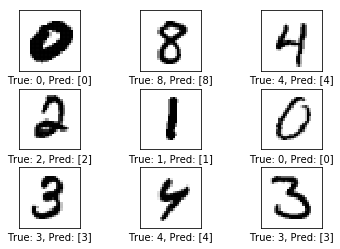

In [18]:
plot_classified_sample(test_loader, sequential_model)

### Examples of Mis-Classified Images

We define a function to sample and plot nine mis-classified images from the test-set.

In [20]:
def plot_misclassified_sample(dataset_loader, model):
    data_iter = iter(dataset_loader)
    misclassified, prediction, correct_cls = [], [], []
    # Fetch enough samples from the dataset to collect at least 9 misclassified samples
    for images, labels in data_iter:
        if cuda:
            images = images.cuda()
        images = Variable(images, volatile=True)
        pred_scores = model(images)
        predicted = array_from_tensor(pred_scores.data.max(1, keepdim=True)[1]).squeeze()
        incorrect = (predicted != labels.numpy())
        misclassified.extend(array_from_variable(images)[incorrect])
        prediction.extend(predicted[incorrect])
        correct_cls.extend(labels.numpy()[incorrect])
        if len(misclassified) >= 9:
            break
            
    plot_images(images=misclassified[0:9],
            cls_true=correct_cls[0:9],
            cls_pred=prediction[0:9])

We can then plot some examples of mis-classified images.

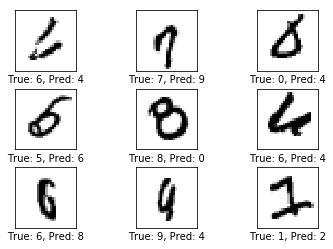

In [23]:
plot_misclassified_sample(test_loader, sequential_model)

## Functional Model

The Pytorch API also supports a different way to described the model: the functional API, found under package `torch.nn.functional`. It can be used to construct more complicated networks. To demonstrate its usage, we will build again the model previously built with the sequential API.

Pytorch provides class `nn.Module` as a container for network models; by deriving our class from it, we can use its services. Note that we are deriving from an `nn.Mudule` here for convenience, but using the functional API doesn't require it, and we could adopt `nn.Module` and use the sequential API instead. For an example of mixing sequential and functional API in a sub-class of `nn.Module`, see the [Deep Learning with PyTorch: A 60 Minute Blitz](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network).

In [25]:
class FunctionalModel(nn.Module):
    def __init__(self):
        super(FunctionalModel, self).__init__()

        def get_conv_weight_and_bias(n_input, n_output, k1, k2):
            w = Parameter(torch.Tensor(n_output, n_input, k1, k2))
            stdv = 1. / math.sqrt(n_input)
            nn.init.uniform(w, -stdv, stdv)
            b = Parameter(torch.Tensor(n_output))
            nn.init.uniform(b, -stdv, stdv)
            return w, b

        def get_linear_weight_and_bias(n_input, n_output):
            w = Parameter(torch.Tensor(n_output, n_input))
            stdv = 1. / math.sqrt(w.size(1))
            nn.init.uniform(w, -stdv, stdv)
            b = Parameter(torch.Tensor(n_output))
            nn.init.uniform(b, -stdv, stdv)
            return w, b

        conv1_kernel_size = 5
        assert ((conv1_kernel_size - 1) % 2 == 0)
        self.conv1_pad = int((conv1_kernel_size - 1) / 2)
        conv2_kernel_size = 5
        assert ((conv2_kernel_size - 1) % 2 == 0)
        self.conv2_pad = int((conv2_kernel_size - 1) / 2)

        self.conv1_w, self.conv1_b = get_conv_weight_and_bias(n_input=1, n_output=16, k1=conv1_kernel_size,
                                                              k2=conv1_kernel_size)
        self.conv2_w, self.conv2_b = get_conv_weight_and_bias(n_input=16, n_output=36, k1=conv2_kernel_size,
                                                              k2=conv2_kernel_size)
        self.fc1_w, self.fc1_b = get_linear_weight_and_bias(n_input=1764, n_output=128)
        self.fc2_w, self.fc2_b = get_linear_weight_and_bias(n_input=128, n_output=num_classes)

    def forward(self, x):
        x = F.conv2d(input=x, weight=self.conv1_w, bias=self.conv1_b, padding=self.conv1_pad)
        x = F.max_pool2d(F.relu(x), 2)
        x = F.conv2d(input=x, weight=self.conv2_w, bias=self.conv2_b, padding=self.conv2_pad)
        x = F.max_pool2d(F.relu(x), 2)
        x = x.view(x.size(0), -1)  # Flatten but keep the same batch size
        x = F.linear(input=x, weight=self.fc1_w, bias=self.fc1_b)
        x = F.relu(x)
        x = F.linear(input=x, weight=self.fc2_w, bias=self.fc2_b)
        return x


functional_model = FunctionalModel()

if cuda:
    functional_model.cuda()

As you see in the code above, using the fucntional API requires us to define and initialize the weight and bias matrices for the convolutional and linear (fully-connected) layers. I am initializing them the way the sequential model does, from a uniform distribution, in order to obtain results that are comparable.

### Choice of an Optimizer

Before training the NN, we need to choose an optimizer; like we did when we used the sequential API, we pick an Adam optimizer with loss rate set to 0.001.

In [27]:
optimizer = optim.Adam(params=functional_model.parameters(), lr=1e-3)

### Training

The same function defined to train the sequential model can train the functional model just implemented.

In [28]:
for epoch in range(epochs):
    train(epoch, functional_model, optimizer, train_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.130369
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.101950
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.082432
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.088976
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.106579
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.072245
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.041182
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110075
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014456
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.049489
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.067239
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.118022
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.067164
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.066124
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020216
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.005443
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.035654
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.028885
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.010577
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.033803


### Evaluation

Once the model has been trained we can evaluate its performance on the test-set. The function defined to test the sequential model will do here as well.

In [29]:
test(functional_model, test_loader)


Test set: Average loss: 0.0450, Accuracy: 9860/10000 (99%)



### Examples of Mis-Classified Images

We can plot some examples of images from the test-set mis-classified by the functional model.

First we get the predicted classes for all the images in the test-set:

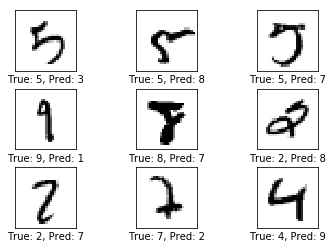

In [30]:
plot_misclassified_sample(test_loader, functional_model)

## Save & Load Model

We can save the model and load it again to make predictions.

This is the file-path where we want to save the Pytorch model.

In [32]:
saved_model_path = 'model.p'

We now save the model state dictionary, which will be enough to make predictions with the same model. To be able to resume the computation with the saved model, we would need to save additional information, such as the model parameters and optimizer. For an example of saving and resuming the computation, see this [Wide Residual Network](https://github.com/szagoruyko/wide-residual-networks/blob/master/pytorch/main.py).

In [33]:
torch.save(functional_model.state_dict(), saved_model_path)

Delete the model from memory so we are sure it is no longer used.

In [34]:
del functional_model

Re-loading the model requires to instantiate it first.

In [35]:
loaded_model = FunctionalModel()
if cuda:
    loaded_model = loaded_model.cuda()

We can then load its state dictionary.

In [36]:
state_dict = torch.load(saved_model_path)
loaded_model.load_state_dict(state_dict)

Calling `eval()` on the model indicates we plan to use it for inference only, no further training; it is actually necessary if the model includes layers such as Dropout or BatchNorm, not our case.

In [37]:
loaded_model.eval()

FunctionalModel(
)

We then use the restored model to predict the class-numbers for a cuple images.

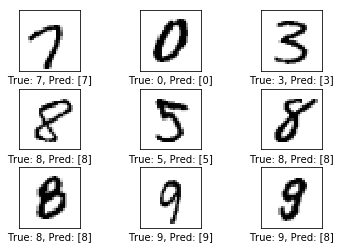

In [40]:
plot_classified_sample(test_loader, loaded_model)

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [49]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [50]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1764)              0         
__________

We count the indices to get the layers we want.

The input-layer has index 0.

In [51]:
layer_input = model3.layers[0]

The first convolutional layer has index 2.

In [52]:
layer_conv1 = model3.layers[2]
layer_conv1

The second convolutional layer has index 4.

In [53]:
layer_conv2 = model3.layers[4]

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [54]:
weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [55]:
weights_conv1.shape

(5, 5, 1, 16)

Plot the weights using the helper-function from above.

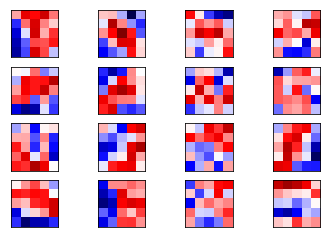

In [56]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [57]:
weights_conv2 = layer_conv2.get_weights()[0]

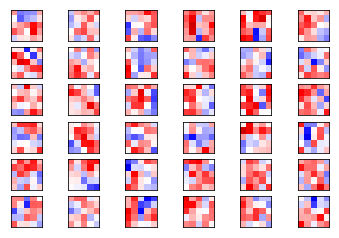

In [58]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Helper-function for plotting the output of a convolutional layer

In [59]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Helper-function for plotting a single image.

In [60]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

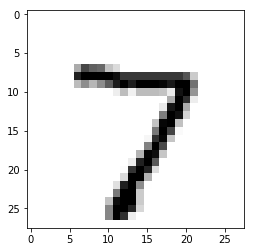

In [61]:
image1 = data.test.images[0]
plot_image(image1)

### Output of Convolutional Layer - Method 1

There are different ways of getting the output of a layer in a Keras model. This method uses a so-called K-function which turns a part of the Keras model into a function.

In [62]:
from tensorflow.python.keras import backend as K

In [63]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

We can then call this function with the input image. Note that the image is wrapped in two lists because the function expects an array of that dimensionality. Likewise, the function returns an array with one more dimensionality than we want so we just take the first element.

In [64]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

(1, 28, 28, 16)

We can then plot the output of all 16 channels of the convolutional layer.

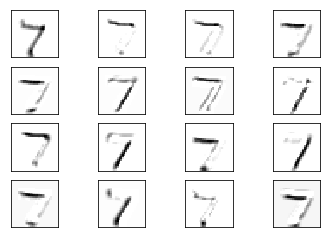

In [65]:
plot_conv_output(values=layer_output1)

### Output of Convolutional Layer - Method 2

Keras also has another method for getting the output of a layer inside the model. This creates another Functional Model using the same input as the original model, but the output is now taken from the convolutional layer that we are interested in.

In [66]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

This creates a new model-object where we can call the typical Keras functions. To get the output of the convoloutional layer we call the `predict()` function with the input image.

In [67]:
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

(1, 14, 14, 36)

We can then plot the images for all 36 channels.

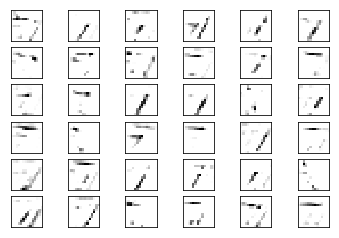

In [68]:
plot_conv_output(values=layer_output2)

## Conclusion

This tutorial showed how to use the so-called *Keras API* for easily building Convolutional Neural Networks in TensorFlow. Keras is by far the most complete and best designed API for TensorFlow.

This tutorial also showed how to use Keras to save and load a model, as well as getting the weights and outputs of convolutional layers.

It seems likely that Keras will be the standard API for TensorFlow in the future, for the simple reason that is already very good and it is constantly being improved. So it is recommended that you use Keras.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train for more epochs. Does it improve the classification accuracy?
* Change the activation function to sigmoid for some of the layers.
* Can you find a simple way of changing the activation function for all the layers?
* Plot the output of the max-pooling layers instead of the conv-layers.
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
* Add and remove some convolutional and fully-connected layers.
* What is the simplest network you can design that still performs well?
* Change the Functional Model so it has another convolutional layer that connects in parallel to the existing conv-layers before going into the dense layers.
* Change the Functional Model so it outputs the predicted class both as a One-Hot encoded array and as an integer, so we don't have to use `numpy.argmax()` afterwards.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.